In [3]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


## The Dataset

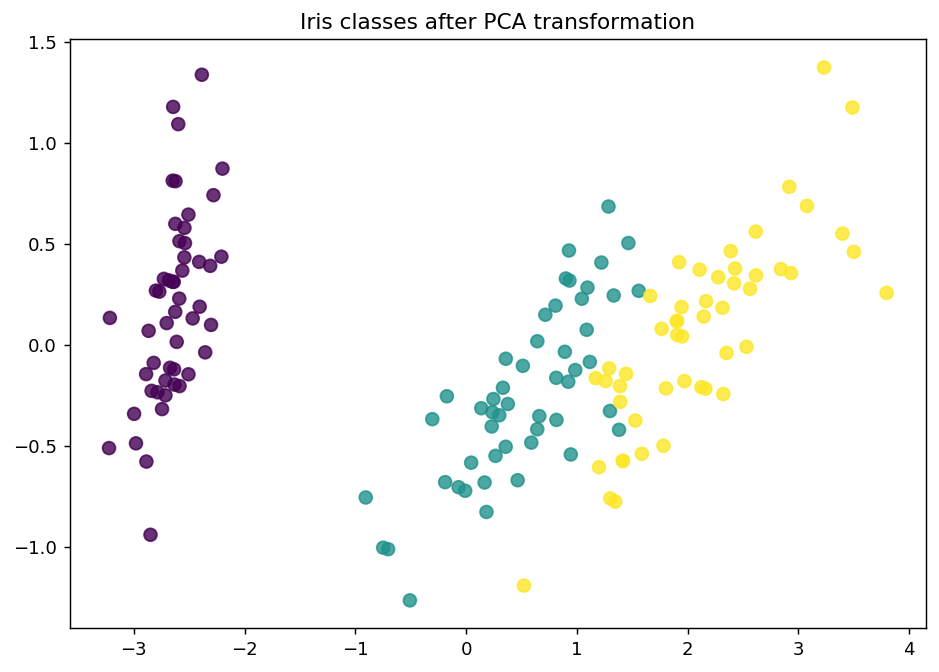

In [8]:
# Set our RNG for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)


iris = load_iris()
X_raw = iris['data']
y_raw = iris['target']

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw)
# Isolate the data we'll need for plotting.
x_component, y_component = transformed_iris[:, 0], transformed_iris[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
plt.title('Iris classes after PCA transformation')
plt.show()
# KNeighborsClassifier

In [9]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

## Active Learning with Ranked batch mode sampling

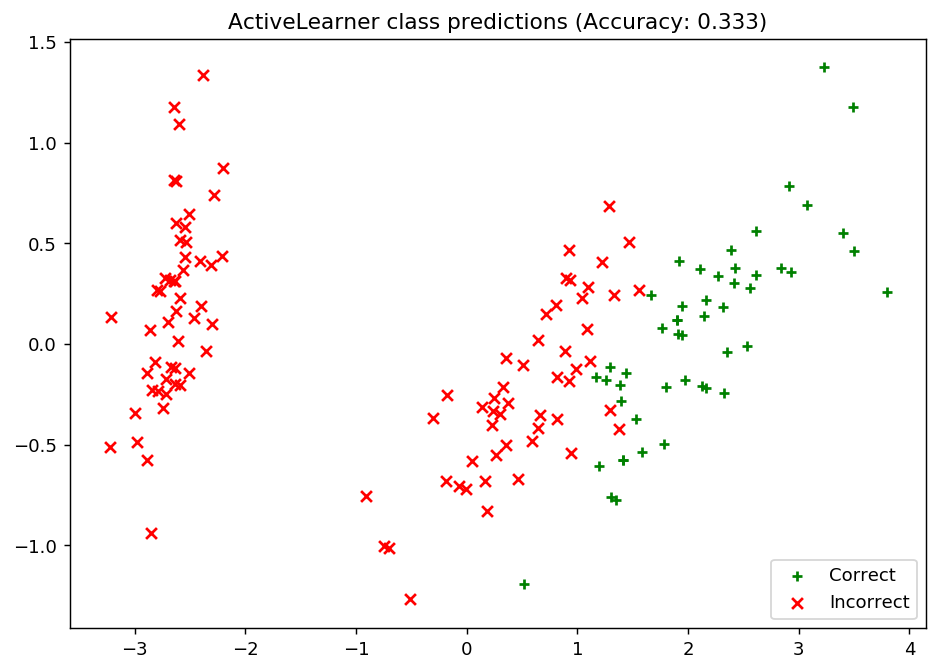

In [19]:
from sklearn.neighbors import KNeighborsClassifier

# Specify our core estimator.
knn = KNeighborsClassifier(n_neighbors=3)
rand_knn = KNeighborsClassifier(n_neighbors=3)

from functools import partial
from modAL.batch import uncertainty_batch_sampling
from modAL.models import ActiveLearner

# Pre-set our batch sampling to retrieve 3 samples at a time.
BATCH_SIZE = 3
preset_batch = partial(uncertainty_batch_sampling, n_instances=BATCH_SIZE)

# Specify our active learning model.
learner = ActiveLearner(
  estimator=knn,

  X_training=X_train,
  y_training=y_train,

  query_strategy=preset_batch
)
# Specify our active learning model.
rand_learner = ActiveLearner(
  estimator=rand_knn,
  X_training=X_train,
  y_training=y_train,

  query_strategy=preset_batch
)
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct')
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect')
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [20]:
def random_query(X, size):
    indices = np.random.choice(range(len(X)), size=size, replace=False)
    return indices, X[indices]

In [21]:
# Pool-based sampling
N_RAW_SAMPLES = 20
N_QUERIES = N_RAW_SAMPLES // BATCH_SIZE

performance_history = [unqueried_score]
rand_performance_history = [unqueried_score]

X_pool_rand = X_pool.copy()
y_pool_rand = y_pool.copy()

for index in range(N_QUERIES):
    query_index, query_instance = learner.query(X_pool)
    rand_query_index, rand_query_instance = random_query(X_pool_rand, BATCH_SIZE)
    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool[query_index], y_pool[query_index]
    X_r, y_r = X_pool[rand_query_index], y_pool[rand_query_index]
    
    learner.teach(X=X, y=y)
    rand_learner.teach(X=X_r, y=y_r)
    
    # Remove the queried instance from the unlabeled pool.
    X_pool = np.delete(X_pool, query_index, axis=0)
    y_pool = np.delete(y_pool, query_index)
    
    X_pool_rand = np.delete(X_pool_rand, rand_query_index, axis=0)
    y_pool_rand = np.delete(y_pool_rand, rand_query_index)

    # Calculate and report our model's accuracy.
    model_accuracy = learner.score(X_raw, y_raw)
    rand_model_accuracy = rand_learner.score(X_raw, y_raw)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
    print('Random Choice Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=rand_model_accuracy))
    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)
    rand_performance_history.append(rand_model_accuracy)



Accuracy after query 1: 0.8867
Random Choice Accuracy after query 1: 0.5600
Accuracy after query 2: 0.8400
Random Choice Accuracy after query 2: 0.8933
Accuracy after query 3: 0.9267
Random Choice Accuracy after query 3: 0.8933
Accuracy after query 4: 0.9133
Random Choice Accuracy after query 4: 0.9067
Accuracy after query 5: 0.9600
Random Choice Accuracy after query 5: 0.9067
Accuracy after query 6: 0.9467
Random Choice Accuracy after query 6: 0.9067


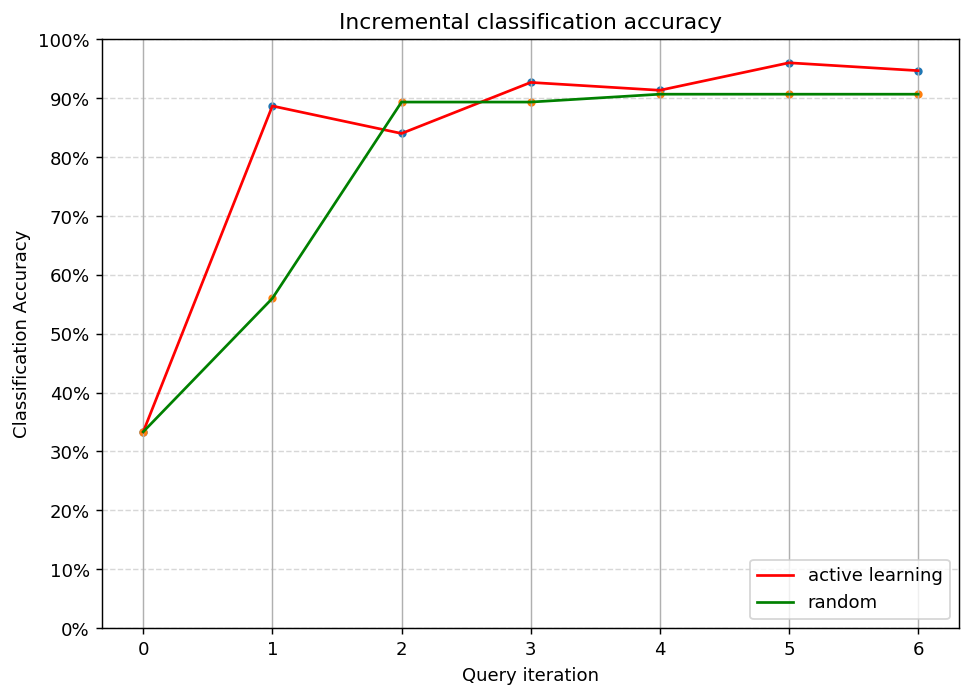

In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history, c='r', label='active learning')
ax.scatter(range(len(performance_history)), performance_history, s=13)
ax.plot(rand_performance_history, c='g', label='random')
ax.scatter(range(len(performance_history)), rand_performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=N_QUERIES + 3, integer=True))
ax.xaxis.grid(True)

ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_ylim(bottom=0, top=1)
ax.yaxis.grid(True, linestyle='--', alpha=1/2)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend(loc='lower right')
plt.show()